# Breast Cancer Detection using Machine Learning

## **nickname on biendata.com: Dracarys**
## *rank: 17*

In [0]:
# !pip install tensorflow-gpu




##  enviroment and global variables 

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import random

from collections import Counter
from pprint import pprint

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(f"TensorFlow version: {tf.__version__}")
print(f"test GPU: {tf.test.gpu_device_name()}")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.1.0
test GPU: /device:GPU:0
Num GPUs Available:  1


In [0]:
%load_ext tensorboard

In [0]:
#!cp /content/drive/My\ Drive/dataset/test.tar.gz ./
#!cp /content/drive/My\ Drive/dataset/train.tar.gz ./
#!tar -zxvf train.tar.gz
#!tar -zxvf test.tar.gz

* if certain directory below does not exist, please create manually.

In [0]:
TRAIN_CSV = "./train/feats.csv"
TRAIN_IMG_DIR = "./train/images"

TEST_CSV = "./test/feats.csv"
TEST_IMG_DIR = "./test/images"


CLEAN_DATA_FILE = "./cleaned_data.csv"

MODEL_DIR = "./model"
RESULT_FILE = "./submission.csv"

LOG_DIR = "./log"

dir_list = [MODEL_DIR, LOG_DIR] 
for d in dir_list: 
    if not os.path.exists(d):
        os.makedirs(d)
        print(f"directory: {d} is created.")


#image size for CNN input
IMG_HEIGHT = 320
IMG_WIDTH = 320

## data anaylysis
to start with, we need to get some basic understand of the data. In the training data set, we can find a few different colums for each record.

***id***: string, which related to one or more ultrasound images.

***age***: int Age of the patient

***HER2***: int Scale (0-3) of how strongly HER2 (marker for genetic predisposition
for breast cancer) is detected

***P53***: bool Whether P53 (marker for genetic predisposition for cancer) is positive 

***molecular subtype***: int Molecular subtype of breast cancer, there are four types of
molecular subtypes in the dataset (1: Luminal A, 2: Luminal
B, 3: HER2-Enriched, 4:Triple Negative)

In this study, ***molecular subtype*** is the preidction target/label. The goal is to create a machine learning model to utilze the record of  ***id(the ultrasound images)***, ***age***, ***pP53*** to predict the ***molecular subtype***. This problem can be categorized as a multi-class classification problem.


It can be found that the sample distribution of ***molecular subtype*** is not balanced. This may cause bias in machine learning training and needs to be addressed.

training data overview


,id,age,HER2,P53,molecular_subtype
0,8a1af6f74cafc720511888998f2f361767c77965a07464...,48,3,True,3
1,b18adad8c39bb458f208581fe40e9be7b04f2b49be04b0...,54,3,False,2
2,8b9af020d0e621168fd0f3913f2cd74e8bb5ea85f61ee0...,55,2,True,3
3,1a0e54f07794fbb95a0fd7f0b4ef6f79ef1a9c83dbaa05...,66,0,False,4
4,2805706a656b013743d84357d5ffa44536e19d18f0509f...,31,0,False,1


record count: 200



,age,HER2,molecular_subtype
count,200.000000,200.000000,200.000000
mean,53.275000,1.190000,1.985000
std,11.852077,1.157844,0.823508
min,29.000000,0.000000,1.000000
25%,45.000000,0.000000,1.000000
50%,51.500000,1.000000,2.000000
75%,61.000000,2.000000,2.000000
max,83.000000,3.000000,4.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb742901b00>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7428098d0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7427ccb00>]],
      dtype=object)

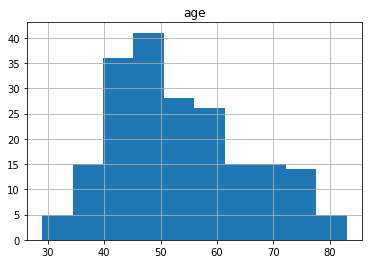

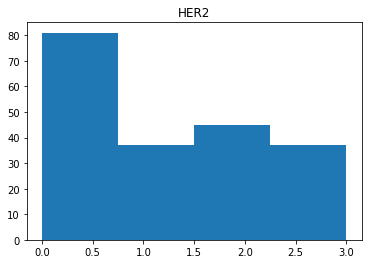

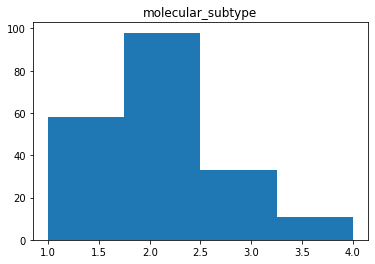

In [9]:
train_df = pd.read_csv(TRAIN_CSV)
print("training data overview")
train_df.head()
print(f"record count: {train_df.shape[0]}\n")
train_df.describe()
train_df.hist("age", grid=True)
train_df.hist("HER2", bins = train_df["HER2"].nunique(), grid=False)
train_df.hist("molecular_subtype", bins = train_df["molecular_subtype"].nunique(), grid=False)

In [10]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()
test_df.describe()

,id,age,HER2,P53
0,d6b47f0c2ccbbd7923e37dc434ab25445df6bc060d5338...,57,0,False
1,2e9d400ee8450c30d19c43a20e9da770774d3169da4574...,36,0,False
2,72f92da6ca6d521221baee367b5c76fcbfe61edc00c0bc...,81,0,False
3,ca7e160144dd6f459e2b18c48a33d4a53d09de5d7c2557...,82,0,False
4,d65889918d2b9073e7601c2ba67c3a9d26f60612f14e93...,59,2,False


,age,HER2
count,87.000000,87.000000
mean,52.333333,1.160920
std,12.508292,1.160128
min,19.000000,0.000000
25%,45.000000,0.000000
50%,52.000000,1.000000
75%,59.500000,2.000000
max,82.000000,3.000000


## data preprocessing

In this study we will focus on using the ultrasound images with deep learning to do the prediction. Since this technique has been proved to be powerful [1](https://arxiv.org/abs/1606.05718) [2](https://ieeexplore.ieee.org/abstract/document/7405343/) and need relatively small domain knowledge. 

In the record, each **id** may have more than one image. Thus firstly it is necessary to create the one to one mapping between image and label. The **age** is normalized by dividing 100, and the **"P53"** is converted to binary integer value 0, 1 for future processing.

In [12]:
f = open(CLEAN_DATA_FILE, "w")

cleaned_data = []
for idx, row in train_df.iterrows():
    normalized_age = row["age"]/100.0
    if row["P53"] is True:
        P53_value = 1.0
    else:
        P53_value = 0.0
    
    image_path_list = glob.glob(os.path.join(TRAIN_IMG_DIR, row["id"], "*.*"))
    for image_path in image_path_list:
        line = f'{image_path}, {normalized_age}, {row["HER2"]}, {P53_value}, {row["molecular_subtype"]}\n'
        cleaned_data.append(line)
        #_ = f.write(f'{image_path}, {row["molecular_subtype"]}\n')


random.shuffle(cleaned_data)
f.writelines(cleaned_data)
f.close()
print(f" total mapping count {len(cleaned_data)} stored in {CLEAN_DATA_FILE} with format: 'image path, label' in each line.")

#with open(CLEAN_DATA_FILE, 'r') as f:
#    print(f.read())

 total mapping count 925 stored in ./cleaned_data.csv with format: 'image path, label' in each line.


After last step, we can found total **925** image to label relation mappings are created. We also need to re-do the statistics on different labels as each **id** may have different count of images.

For a typical multi class classification problem, one-hot encoding is a common practice the convert the categorical label in to a one-hot fashion, which will be used as input for supervised learning. So as to the ***HER2*** and **P53** value.

In [15]:
train_image_path = []
train_raw_label = []

her2_value_list = []
p53_value_list = []
normalized_age_list = []

with open(CLEAN_DATA_FILE, "r") as f:
    lines = f.readlines()
    for line in lines:
        image_path, normalized_age, her2_value, p53_vale, label = line.split(",")
        label = label.strip() 
        train_image_path.append(image_path)
        train_raw_label.append(label)

        normalized_age_list.append(normalized_age.strip())
        her2_value_list.append(her2_value.strip())
        p53_value_list.append(p53_vale.strip())

print("different label count:")
print(sorted(Counter(list(train_raw_label)).items()))        

train_image_path = np.asarray(train_image_path)
train_raw_label = np.asarray(train_raw_label).reshape(-1, 1)
train_image_path, train_raw_label = shuffle(train_image_path, train_raw_label)

label_encoder = OneHotEncoder(sparse=False)
train_onehot_label = label_encoder.fit_transform(train_raw_label)
print("\nlabel none-hot encoding:")
print(np.unique(train_onehot_label, axis = 0))
#print(f"{train_image_path.shape}, {train_onehot_label.shape}")


her2_value_list = np.asarray(her2_value_list).reshape(-1, 1)
her2_encoder = OneHotEncoder(sparse=False)
her2_onehot = her2_encoder.fit_transform(her2_value_list)
print("\nHER2 one-hot encoding:")
print(np.unique(her2_onehot, axis = 0))

p53_value_list = np.asarray(p53_value_list).reshape(-1, 1)
p53_encoder = OneHotEncoder(sparse=False)
p53_onehot = p53_encoder.fit_transform(p53_value_list)
print("\nP53 one-hot encoding:")
print(np.unique(p53_onehot, axis = 0))



different label count:
[('1', 267), ('2', 472), ('3', 136), ('4', 50)]

label none-hot encoding:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

HER2 one-hot encoding:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

P53 one-hot encoding:
[[0. 1.]
 [1. 0.]]


We can found that the count of each label is not balanced by a large ratio. 

By examining the images, we can find that the images have differnet format and shapes. These images need to be preprocessed before feed into the deep learning model. 

In the image preprocessing function **preprocess_image()**, the images will be resized to the same shape, and each pixel value is normalized to [0, 1], which is also required by the deep learning model training process. We also need to create the train/test data split for validation.

In [20]:
def preprocess_image(image_path):
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = np.asarray(image)

    return image


train_X = []
for image_path in train_image_path:
    train_X.append(preprocess_image(image_path))
    
train_X = np.asarray(train_X)
train_Y = train_onehot_label

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.15, random_state=42)
print(f"\ntrain X shape: {train_X.shape}, train Y shape: {train_Y.shape}, test X shape:{test_X.shape}, test Y shape: {test_Y.shape}")



train X shape: (786, 320, 320, 3), train Y shape: (786, 4), test X shape:(139, 320, 320, 3), test Y shape: (139, 4)


By now we have prepared the training data: The preprocessed input image(**train_X**), and the one-hot encoding label (**train_Y**).

## build machine learning model 
 The convolutional neural network (CNN) model is suitable for this problem. Here we create two types of model.

 + Simple CNN model, train from scratch
 + transfer learning model, which is proved to be useful[3](https://www.spiedigitallibrary.org/journals/Journal-of-Medical-Imaging/volume-3/issue-3/034501/Digital-mammographic-tumor-classification-using-transfer-learning-from-deep-convolutional/10.1117/1.JMI.3.3.034501.short?SSO=1) 

### 1. simple CNN model

In [0]:
def build_model():
    model = Sequential()
    model.add(Conv2D(16, 3, padding='valid', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, 3, padding='valid', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='valid', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 3, padding='valid', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))
    
    
    model.summary()
    return model



### 2. transfer learning model

In [0]:
def build_transfer_learning_model(base_model):
    
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    
    #model.add(Dense(128, activation = "relu"))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    #model.add(Dense(64, activation = "relu"))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Dense(32, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))
    
    model.summary()
    return model

## model training

Currently there're less than 1000 images for training, which may not be enough and proper argumentation is need. Here we assume that certrain rotation, shift, flip and other operation on the image didn't change the label it belongs. Thus we utilize a ImageDataGenerator() to do the job. 

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(train_X)


#### misc settings for model training

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(LOGDIR, histogram_freq=1)

### simple CNN training

As a multi-class classfication problem, categorical crossentropy loss function is a common choice.
 
In the model training, the imbalanced label(class) distribution is handeling by giving differnet class weight. Class with smaller count will be given higher weight.

In [27]:
model =  build_model() 

optimizer = Adam(
    learning_rate=0.001, epsilon=1e-07, amsgrad=False,)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


y_integers = np.argmax(train_Y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

print(f"class weight: {d_class_weights}")


history = model.fit(datagen.flow(train_X, train_Y, batch_size = 32),  
                    epochs = 20, shuffle = True, 
                    class_weight = d_class_weights,
                    callbacks = [tensorboard_callback], verbose = 1,
                    validation_data = (test_X, test_Y)
                    )
                   

model_file = os.path.join(MODEL_DIR, "simple_cnn_model.h5")
model.save(model_file)
print(f"model: {model_file} saved.")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 318, 318, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 159, 159, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 157, 157, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 76, 76, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 128)      

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

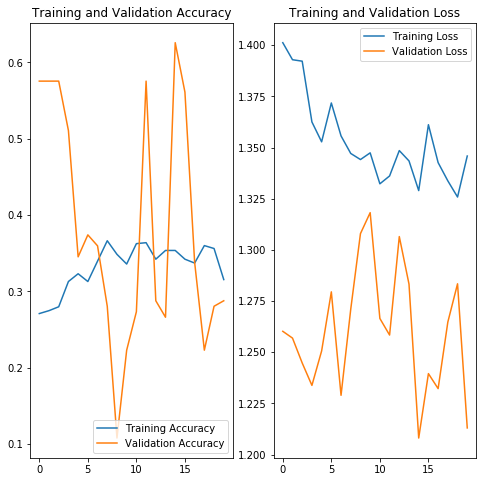

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### transfer Learning

In transfer learning, a pre-trained model (DenseNet121, with ImageNet weight) is used as featue extraction layer.Then a few fully-connect layer is used for the classification.

In [33]:
base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights='imagenet')
transfer_model = build_transfer_learning_model(base_model) # 

optimizer = Adam(
    learning_rate=0.001, epsilon=1e-07, amsgrad=False,)

transfer_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


y_integers = np.argmax(train_Y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

print("class_weight: ", d_class_weights)


history = transfer_model.fit(datagen.flow(train_X, train_Y, batch_size = 32),  
                    epochs=50, shuffle = True, 
                    class_weight = d_class_weights,
                    callbacks = [tensorboard_callback], verbose = 1,
                    validation_data = (test_X, test_Y)
                    )

transfer_model.save(os.path.join(MODEL_DIR, "transfer_learning_model.h5"))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 102400)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                3276832   
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 132       
Total params: 10,314,596
Trainable params: 3,277,028
Non-trainable params: 7,037,568
_________________________________________________________________
class_weight:  {0: 0.8469827586206896, 1: 0.5012755102040817, 2: 1.6794871794871795, 3: 4.36666666666

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

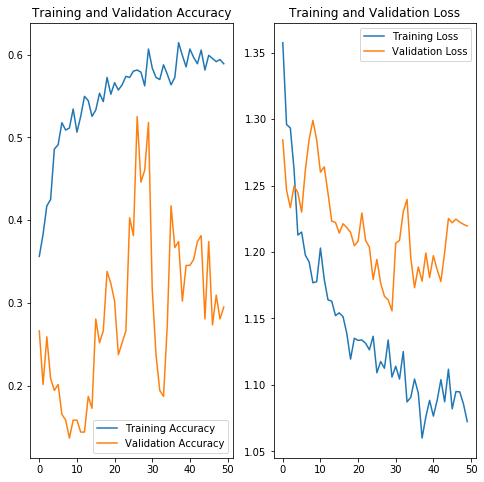

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can found the model did not converge very well and still have room to improve. The transfer learning model performed better in terms of the validation loss. 

For now we will do the prediction with the transfer model we trained.

## do prediction

create a help function to covert output softmax vector to the single digit label.

In [0]:
def predict(model, image_path):
    image = preprocess_image(image_path)
    prediction =  model.predict(np.asarray([image]))
    #print(prediction)
    result = np.argmax(prediction) + 1
    #print(prediction, result)
    return result




## Create final submission

To create the final submission of this contest, it should be noticed that each **id** may have more than images, and the predicted label from differnet images may be different, while the final label should be an unique one. To handle this, the voting method is used. The final label will be the label that most images under that **id** predicted.    

In [41]:
def create_result(model, csv_path, image_dir):
    test_df = pd.read_csv(csv_path)
    test_image_id = list(test_df["id"])
    #print(test_image_id)
    f = open(RESULT_FILE, "w")
    for idx in test_image_id:
        test_image_file_path = glob.glob(os.path.join(image_dir, idx, "*.*"))
        #print(test_image_file_path)
        result = []
        
        for p in test_image_file_path:
            result.append(predict(model, p))
        
        #print(result)
        result = np.asarray(result)
        if result.shape[0] != 0:
            counts = np.bincount(result)
            final = np.argmax(counts)
            #print(f"{idx}, {result}, {final}")
        else:
            print(f"{idx} has no image attached, the final label will set to -1")
            final = -1
        
        f.write(f"{idx},{final}\n")
    
    f.close()
    print(f"the final submission result is saved to {RESULT_FILE}.")

    
create_result(transfer_model, TEST_CSV, TEST_IMG_DIR)
    

the final submission result is saved to ./submission.csv.


## Summary

In this project CNN model is used to predcit breast cancer situation  from the ultrasonic image. Two methods: *simple CNN model, training from scratch*, and *transfer learning* is used.The final result is not very good due to a few possible issues: 

+ the network structure didn't optimized. 
+ the image preprocessing is not enough. In this project we only did simple resizing and normalization. More can be done to improve the feed-in image quality, such as to removed the blak margin for each image, which didn't provide much information.
+ other non-image properties (**age**, **P53**, **HER2**) were not used, which may also provide usefull information.This is addressed in the below TBD part.   

## TBD (not finished):

### mixed model

data preparation

In [47]:
def preprocess_image(image_path):
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = np.asarray(image)

    return image

train_Y = train_onehot_label
train_X = []
train_image = []
train_age = []
train_her2 = []
train_p53 = []
for image_path, normalized_age, her2_v, p53_v in zip(train_image_path, normalized_age_list, her2_onehot, p53_onehot):
    train_X.append([
                    preprocess_image(image_path),
                    float(normalized_age),
                    her2_v,
                    p53_v

    ])
    train_image.append(preprocess_image(image_path))
    train_age.append(np.asarray(float(normalized_age)))
    train_her2.append(np.asarray(her2_v))
    train_p53.append(np.asarray(p53_v))


train_image = np.asarray(train_image)
train_age = np.asarray(train_age)
train_her2 = np.asarray(train_her2)
train_p53 = np.asarray(train_p53)

print(train_image.shape, train_age.shape, train_her2.shape, train_p53.shape)

#train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.15, random_state=42)




(925, 320, 320, 3) (925,) (925, 4) (925, 2)


### create the mixed data generator
 inspired by https://github.com/keras-team/keras/issues/3386

In [0]:
def MixedDataGenerator( X, age_data, her2_data, p53_data, Y, batch_size=32):
    
    while True:
        # suffled indices    
        idx = np.random.permutation( X.shape[0])
        # create image generator
        datagen = ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)

        batches = datagen.flow( X[idx], Y[idx], batch_size=batch_size, shuffle=False)
        
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], 
                   age_data[ idx[ idx0:idx1 ] ],
                   her2_data[ idx[ idx0:idx1 ] ],
                   p53_data[ idx[ idx0:idx1 ] ],
                   ], batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

### create mixed input model

In [0]:
def build_mixed_model():
    image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3))
    age_input = Input(shape=(1,))
    her2_input = Input(shape=(4,))
    p53_input = Input(shape=(2,))

    image_output = Conv2D(32, 3, padding='valid', activation='relu')(image_input)
    image_output = MaxPooling2D()(image_output)
    image_output = Conv2D(64, 3, padding='valid', activation='relu')(image_output)
    image_output = MaxPooling2D()(image_output)
    image_output = Flatten()(image_output)
    image_output = Dense(32)(image_output)
    
    image_output = Dense(16)(image_output)
    image_model = Model(inputs=image_input, outputs=image_output)

    combined = concatenate([image_model.output, age_input, her2_input, p53_input])
   
    final_output = Dense(4, activation='softmax')(combined)
    
    model = Model(inputs=[image_model.input, age_input, her2_input, p53_input], outputs=final_output)
    
    model.summary()

    return model
    


### mixed model training

In [0]:
model =  build_mixed_model() #build_transfer_learning_model() # #

optimizer = Adam(
    learning_rate=0.001, epsilon=1e-07, amsgrad=False,)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


y_integers = np.argmax(train_Y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

print("class_weight: ", d_class_weights)

'''
history = model.fit([train_image, train_age, train_her2, train_p53],  train_Y, batch_size = 32,  
                    epochs=10, shuffle = True, 
                    class_weight = d_class_weights,
                    callbacks = [tensorboard_callback], verbose = 1,
                    
                    )
'''

history = model.fit(MixedDataGenerator(train_image, train_age, train_her2, train_p53, train_Y, batch_size = 32), 
                    epochs=10, shuffle = True, 
                    class_weight = d_class_weights,
                    callbacks = [tensorboard_callback], verbose = 1,
                    
                    )



model_file = os.path.join(MODEL_PATH, "mixed_cnn_model.h5")
model.save(model_file)
print(f"model: {model_file} saved.")

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 318, 318, 32) 896         input_19[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 159, 159, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 157, 157, 64) 18496       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

'\nhistory = model.fit([train_image, train_age, train_her2, train_p53],  train_Y, batch_size = 32,  \n                    epochs=10, shuffle = True, \n                    class_weight = d_class_weights,\n                    callbacks = [tensorboard_callback], verbose = 1,\n                    \n                    )\n'

  ...
    to  
  ['...']
Epoch 1/10
     87/Unknown - 80s 921ms/step - loss: 1.4928 - accuracy: 0.2905

## create final result